## What neighbourhoods share similarities based on Airbnb unit features and property types in Ottawa, ON, Canada?

In the first analysis we built a distribution of Airbnbs by neighbourhood in the city of Ottawa, ON, Canada.  We looked at the airbnb desnity and averegae price broken down between unit types.  We were able to infer some criteria regarding the geolocation and the price/amount of units but in this analysis we'd like a more intelligent grouping of units & neighbourhoods based on actual unit features.  This analysis was inspired by [Geographic Data Science with PySAL and the pydata stack](http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html).

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler
import re
import os
if not os.path.exists('images'):
    os.makedirs('images')
%matplotlib inline

sns.set(style="whitegrid")

Just like in the previous analysis we import `listings.csv` and `neighbourhoods.geojson` into `listings` and `ottawa` dataframes, respectively.

In [2]:
listings = pd.read_csv("./listings.csv")
ottawa = gpd.read_file("./neighbourhoods.geojson")

First we'd like to convert the number of bathrooms description from a text field to a float so we can actively see the number of bathrooms in each unit.

Secondly we'd like to convert the price form a string with a dollar sign into a useable numerical float feature.

In [3]:
listings['bathrooms'] = listings['bathrooms_text'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
listings['price'] = listings['price'].apply(lambda value: re.sub(r'\$|,|%', '', str(value))).astype(float)

We'd like to only focus on features with details relating to the unit itself, such as bathrooms, bedrooms, number of beds, price etc.

In [4]:
unit_details = ['bedrooms', 'bathrooms', 'beds', 'accommodates', 'price']

We want to see the average of these fields over each neighbourhood.

In [5]:
unit_details_averages = listings.groupby('neighbourhood_cleansed')[unit_details].mean()

In order to reduce the dimensionality of the input data set we're going to group the similar property types into new categories.

In [6]:
listings['property_type'].value_counts()

Entire apartment                     718
Private room in house                511
Entire house                         385
Private room in townhouse            201
Entire condominium                   137
Entire guest suite                   132
Private room in apartment            129
Entire townhouse                     110
Private room in bungalow              70
Entire bungalow                       59
Private room in condominium           38
Private room in bed and breakfast     37
Private room in guest suite           25
Entire serviced apartment             24
Entire loft                           20
Entire guesthouse                     14
Room in hotel                         11
Room in boutique hotel                 8
Shared room in house                   7
Entire cottage                         6
Private room in villa                  5
Shared room in apartment               5
Entire cabin                           4
Camper/RV                              4
Shared room in t

In [7]:
def rename_property_types(el):
    '''
    INPUT
    el - an element (string) to be grouped by name
    
    OUTPUT
    string containing a new group name for the element
    
    Groups elements based on the content in its string and returns the group name.
    '''
    if el in ['Entire apartment', 'Entire loft', 'Entire serviced apartment', 'Entire condominium']:
        return 'Entire Condo/Apartment'
    elif el in ['Entire house', 'Entire bungalow', 'Entire townhouse', 'Entire guesthouse']:
        return 'Entire House'
    elif el in ['Private room in house', 'Private room in townhouse', 
                'Entire guest suite', 'Private room in bungalow', 'Private room in bed and breakfast', 
                'Private room in guest suite']:
        return 'Private Room in House'
    elif el in ['Private room in apartment', 'Private room in condominium']:
        return 'Private Room in Condo/Apartment'
    else:
        return el

listings['property_type'] = listings['property_type'].apply(rename_property_types)
listings['property_type'].value_counts()

Private Room in House              976
Entire Condo/Apartment             899
Entire House                       568
Private Room in Condo/Apartment    167
Room in hotel                       11
Room in boutique hotel               8
Shared room in house                 7
Entire cottage                       6
Shared room in apartment             5
Private room in villa                5
Camper/RV                            4
Entire cabin                         4
Shared room in townhouse             3
Private room in loft                 3
Private room in guesthouse           3
Entire chalet                        3
Tiny house                           2
Room in aparthotel                   2
Shared room in bungalow              2
Shared room in cave                  2
Entire villa                         1
Treehouse                            1
Shared room in loft                  1
Shared room in villa                 1
Private room in cabin                1
Yurt                     

We want to consolidate any property type that has less than n=12 values to remove any outliers based on uncommon property types like a Yurt so we don't skew the clustering algorithm based on uncommon housing styles.

In [8]:
property_type_value_counts = listings['property_type'].value_counts()
listings['property_type'] = np.where(listings['property_type'].isin(property_type_value_counts.index[property_type_value_counts >= 10]), listings['property_type'], 'Other')
listings['property_type'].value_counts()

Private Room in House              976
Entire Condo/Apartment             899
Entire House                       568
Private Room in Condo/Apartment    167
Other                               72
Room in hotel                       11
Name: property_type, dtype: int64

Next, we want to one-hot-vector the property type feature and then count the number of each unit type by neighbourhood.  We then want to calculate the percentage of each unit type that appears in each neighbourhood.

In [9]:
one_hot_property_types = pd.get_dummies(listings['property_type'])
property_types_count_by_hood = one_hot_property_types.join(listings['neighbourhood_cleansed']).groupby('neighbourhood_cleansed').sum()
property_types_percent_by_hood = (property_types_count_by_hood * 100.).div(property_types_count_by_hood.sum(axis=1), axis=0)
property_types_percent_by_hood.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, Alta Vista to West Carleton-March
Data columns (total 6 columns):
Entire Condo/Apartment             23 non-null float64
Entire House                       23 non-null float64
Other                              23 non-null float64
Private Room in Condo/Apartment    23 non-null float64
Private Room in House              23 non-null float64
Room in hotel                      23 non-null float64
dtypes: float64(6)
memory usage: 1.3+ KB


In [10]:
unit_details_averages_property_types = unit_details_averages.join(property_types_percent_by_hood)

Since it's a clustering algorithm we want to scale the input.  We use min max scaler to bring the values between 0 and 1 for input to the scaling algorithm.

In [11]:
scaler = MinMaxScaler()
scaler.fit(unit_details_averages_property_types)
unit_details_averages_property_types_scaled = pd.DataFrame(scaler.transform(unit_details_averages_property_types), index=unit_details_averages_property_types.index, columns=unit_details_averages_property_types.columns)

Just a reminder to what the `ottawa` demographic looks like by neighborhood:

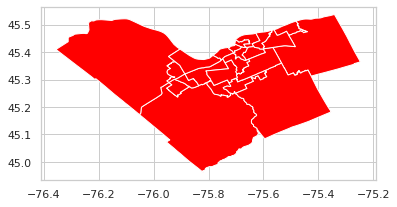

In [12]:
ottawa.plot(color='red');

We use sklearn kMeans clustering with N clusters on the input df that contains aggregate features about the unit type describing each neighbourhood in Ottawa.

In [13]:
X_input = ottawa[['geometry', 'neighbourhood']].join(unit_details_averages_property_types_scaled, on='neighbourhood').dropna()

In [14]:
np.random.seed(42)
num_clusters = 5
kmCl = cluster.KMeans(n_clusters=num_clusters)

In [15]:
kmCls = kmCl.fit(X_input.drop(['geometry', 'neighbourhood'], axis=1).values)

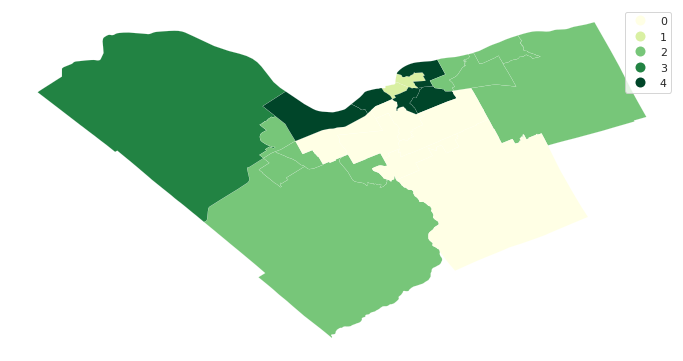

In [16]:
f, ax = plt.subplots(1, figsize=(12, 10))
X_input.assign(cl=kmCls.labels_).plot(column='cl', categorical=True, cmap='YlGn', legend=True, linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.savefig('./images/'+'kMeansClusters'+'.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

Interstingly enough we can see clear clusters that somewhat respect the geolocation of the Ottawa.  Some intial insights about each cluster that we can see from the map are that downtown and immediate surroundings are their own clusters.  Cottage country in the west end is its own cluster while the suburbs in the east and west are grouped together.  Lastly the far south and the west end of the city are grouped together.

Let's dive deeper into the reasoning behind these clusters.  We'll take a look into the average aggregate unit details per cluster first and then look at the distrubution of property type.

In [17]:
def show_cluster_details(cols, savefile, df=unit_details_averages_property_types_scaled):
    '''
    INPUT
    cols - columns in a dataframe to plot
    df - dataframe with clustered features to be plotted
    
    OUTPUT
    a stacked bar plot highlighting the features relevance in each cluster of a clustered dataframe
    
    Takes and input dataframe and assigns cluster labels from a clustering model.  Groups features specified in cols
    and plots a stacked bar chart highlighting the feature relevance in each cluster.
    '''
    df = df.reindex(X_input['neighbourhood']).assign(cl=kmCls.labels_)
    df = df[cols + ['cl']]
    cluster_percents = df.groupby('cl').mean()
    f, ax = plt.subplots(1, figsize=(9, 9))
    cluster_percents.plot(kind='bar', stacked=True, ax=ax, cmap='YlGn', linewidth=0)
    ax.legend(ncol=1, bbox_to_anchor=(1.50, 0.5), loc='right');
    ax.grid(False);
    ax.set_xlabel('Cluster');
    plt.savefig('./images/'+savefile+'.png', dpi=300, bbox_inches='tight', pad_inches=0)

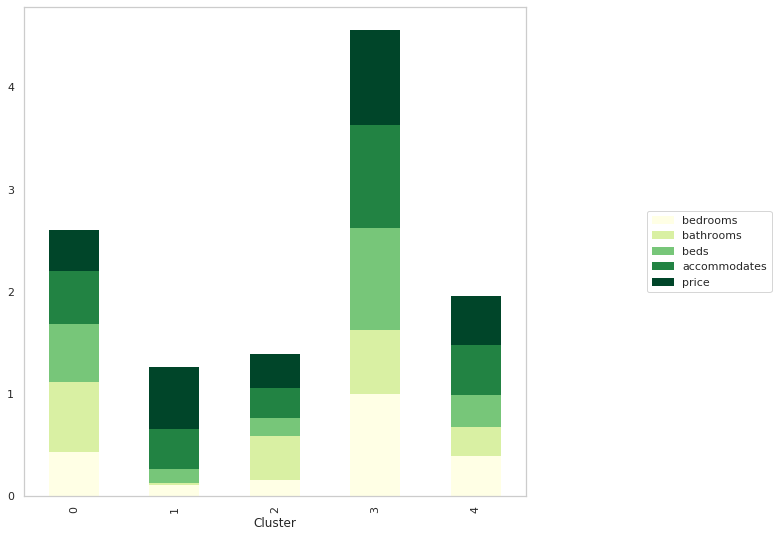

In [18]:
show_cluster_details(unit_details, 'unit_details')

It can be seen that the cluster `3` holds both the most expensive and biggest units, making sense since we determined above that this is cottage country.  `1` and `4` are downtown and surrounding neighbourhoods, the size of these units is very small but both are pricey.  `2` holds smaller, cheaper units than `0` which has slightly larger, pricier units.

The findings make sense when paired with the geography above, below will illustrate the housing type distribution in these clusters.

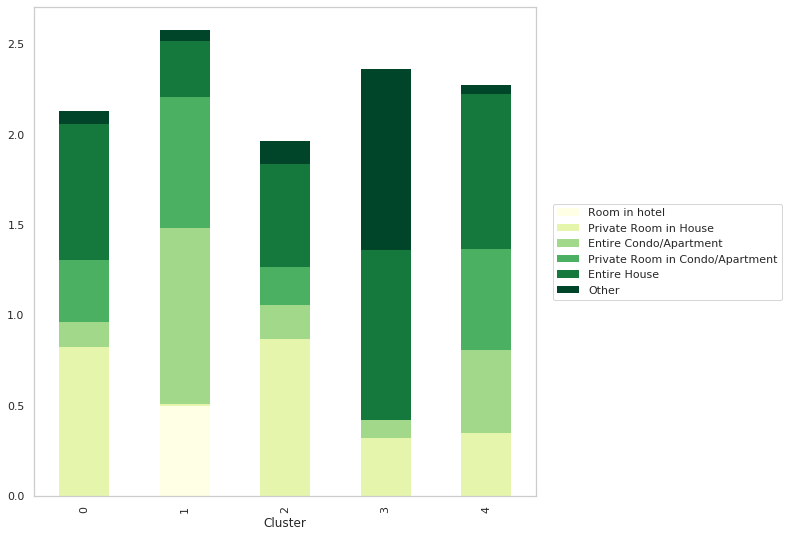

In [19]:
show_cluster_details(list(set(unit_details_averages_property_types.columns).difference(set(unit_details))), 'room_type')

Let's begin with clusters `1` and `4`, the downtown and surrounding area.  `1` has the largest distribution of condos and all related to apartments while `4` distributes largely across entire house and entire or private rooms in apartments.  Cluster `0` and `2`, the suburbs, have a large distribution across private room in house, and entire house categories.  `3` holds many units in the other and entire house categories, supporting the thoery of this being largely cottage country.